In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
import itertools

from spicy_snow.retrieval import retrieval_from_parameters

In [2]:
lidar_ds = xr.open_dataset(Path('~/scratch/spicy/SnowEx-Data-params/Banner_2021-03-15.nc'))

In [15]:
from spicy_snow.processing.s1_preprocessing import s1_dB_to_power

def add_confidence_angle(dataset: xr.Dataset, inplace: bool = False):
    """
    Function to add confidence angle to dataset.

    Confidence Angle = angle[ abs(dVH/dt / mean(dVH/dt)), abs(dVV/dt / mean(dVV/dt)) ]

    Args:
    dataset: Xarray Dataset of sentinel images to add confidence angle to
    inplace: boolean flag to modify original Dataset or return a new Dataset

    Returns:
    dataset: Xarray dataset of sentinel image with confidence interval in 
    """
    ds_amp = s1_dB_to_power(dataset).copy()
    ds_amp['deltaVH_amp'] = ds_amp['s1'].sel(band = 'VH').diff(1)
    ds_amp['deltaVV_amp'] = ds_amp['s1'].sel(band = 'VV').diff(1)

    ds_amp['deltaVH_norm'] = np.abs(ds_amp['deltaVH_amp'] / ds_amp['deltaVH_amp'].mean())
    ds_amp['deltaVV_norm'] = np.abs(ds_amp['deltaVV_amp'] / ds_amp['deltaVV_amp'].mean())

    ds_amp['confidence'] = (ds_amp['deltaVH_norm'].dims, np.angle(ds_amp['deltaVV_norm'].values + ds_amp['deltaVH_norm'].values * 1j))
    dataset['confidence'] = ds_amp['confidence'].mean('time')

    if not inplace:
        return dataset

In [16]:
lidar_ds = add_confidence_angle(lidar_ds)

In [8]:
optimal_a = 1.1
optimal_b = 2.0
optimal_c = 0.39
new_ds = retrieval_from_parameters(lidar_ds, A = optimal_a, B = optimal_b, C = optimal_c, wet_SI_thresh = 0, freezing_snow_thresh = 1, wet_snow_thres = -2)

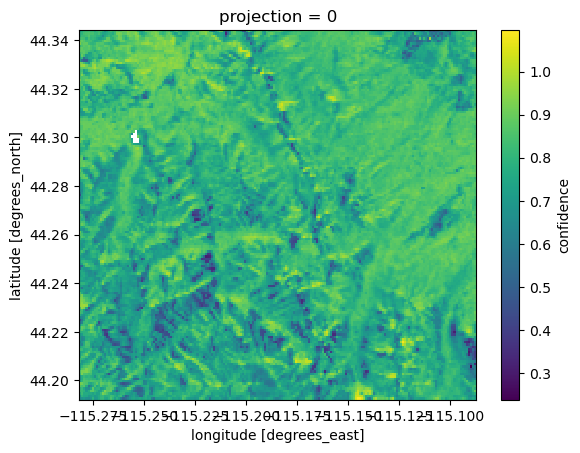

In [14]:
lidar_ds['confidence'].plot()

In [11]:
lidar_ds.attrs['param_A']

1.4

In [10]:
new_ds.to_netcdf('~/Banner_2021-03-15.nc')

(array([1.000000e+00, 1.670000e+02, 1.531900e+04, 2.441990e+05,
        1.797421e+06, 3.305800e+05, 8.683100e+04, 5.173000e+03,
        4.000000e+01, 5.000000e+00]),
 array([-2.72632976, -2.09335728, -1.4603848 , -0.82741232, -0.19443984,
         0.43853264,  1.07150511,  1.70447759,  2.33745007,  2.97042255,
         3.60339503]),
 <BarContainer object of 10 artists>)

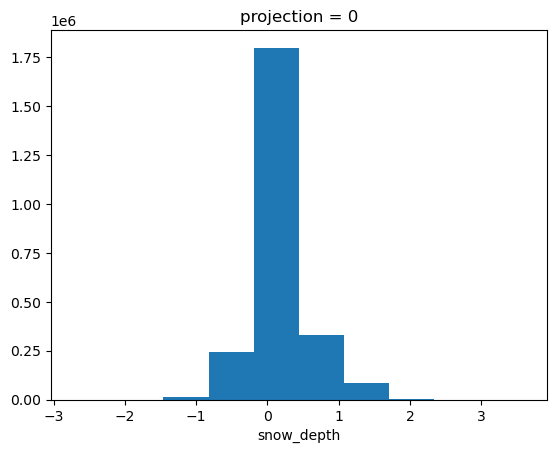

In [7]:
(new_ds['snow_depth']-lidar_ds['snow_depth']).plot()

In [74]:
optimal_a = 1.1
optimal_b = 2.0
optimal_c = 0.39

dataset = xr.open_dataset(f).load() # Open dataset 
td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(lidar_ds.attrs['lidar-flight-time']))
closest_ts_idx = np.where(td == td.min())[0][0]
closest_ts = lidar_ds.time[closest_ts_idx]

ds_optimal, lidar_optimal = calc_snowdepth(dataset, optimal_a, optimal_b, optimal_c, closest_ts,lidar_ds)
ds_a25down, lidar_a25down = calc_snowdepth(dataset, optimal_a-optimal_a*0.25, optimal_b, optimal_c, closest_ts,lidar_ds)
ds_a25up, lidar_a25up = calc_snowdepth(dataset, optimal_a+optimal_a*0.25, optimal_b, optimal_c, closest_ts,lidar_ds)
    
ds_b25down, lidar_b25down = calc_snowdepth(dataset, optimal_a, optimal_b-optimal_b*0.25, optimal_c, closest_ts,lidar_ds)
ds_b25up, lidar_b25up = calc_snowdepth(dataset, optimal_a, optimal_b+optimal_b*0.25, optimal_c, closest_ts,lidar_ds)
    
ds_c25down, lidar_c25down = calc_snowdepth(dataset, optimal_a, optimal_b, optimal_c-optimal_c*0.25, closest_ts,lidar_ds)
ds_c25up, lidar_c25up = calc_snowdepth(dataset, optimal_a, optimal_b, optimal_c+optimal_c*0.25, closest_ts,lidar_ds)

hans = lidar_ds.snow_depth.where(lidar_optimal>=0).sel(time=closest_ts, method = 'nearest') #2.5, 0.2, 0.55
h2,_ = calc_snowdepth(dataset, 2, 0.5, 0.44, closest_ts,lidar_ds)

Text(0.5, 1.0, 'A = 1.1, B = 2.0')

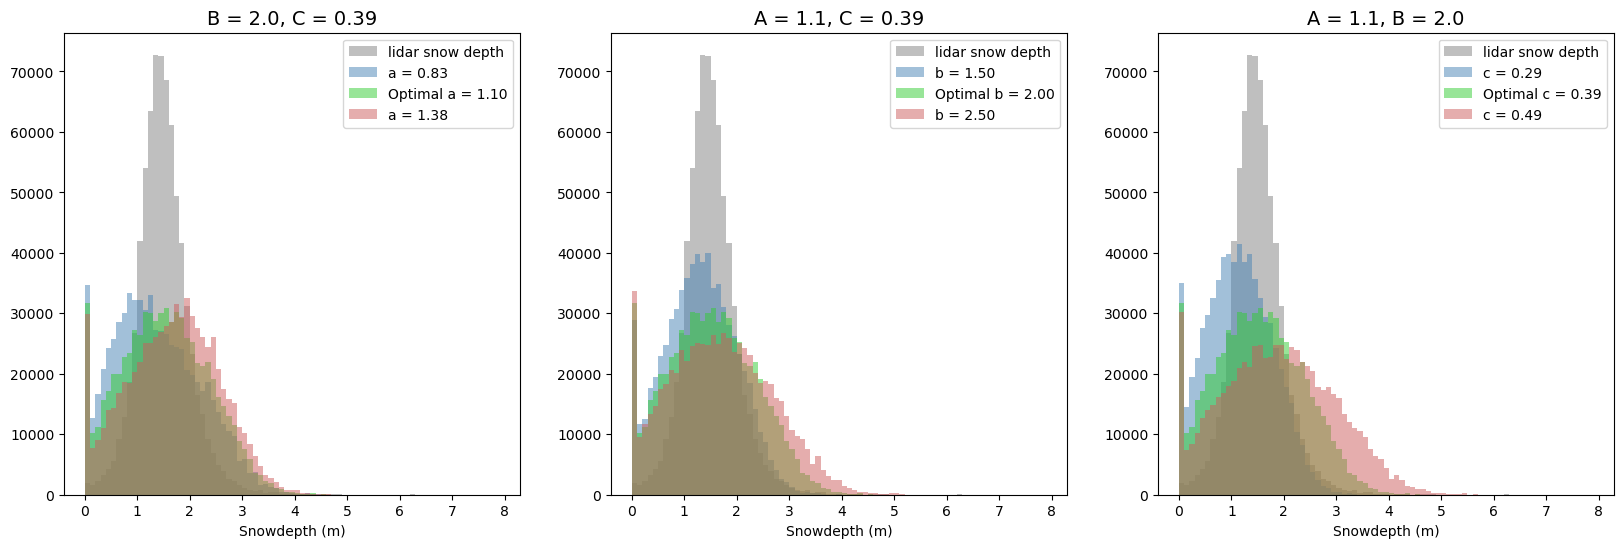

In [75]:
fig, ax = plt.subplots(1,3,figsize = (20,6))

bins = np.arange(0,8,0.1)
ax[0].hist(lidar_optimal.values.flatten(), bins, alpha = 0.25, color = 'black', label = 'lidar snow depth')
# ax[0].hist(hans.values.flatten(), bins, alpha = 0.5, color = 'yellow', label = 'Hans S1 snow depth')
# ax[0].hist(h2.values.flatten(), bins, alpha = 0.5, color = 'orange', label = 'Hans S1 snow depth')
ax[0].hist(ds_a25down.values.flatten(), bins, alpha = 0.5, color = 'steelblue', label = f'a = {optimal_a-0.25*optimal_a:0.2f}')
ax[0].hist(ds_optimal.values.flatten(), bins, alpha = 0.5, color = 'limegreen', label = f'Optimal a = {optimal_a:0.2f}')
ax[0].hist(ds_a25up.values.flatten(), bins, alpha = 0.5, color = 'indianred', label = f'a = {optimal_a+0.25*optimal_a:0.2f}')
ax[0].set_xlabel('Snowdepth (m)')
ax[0].legend()
ax[0].set_title(f'B = {optimal_b}, C = {optimal_c}', fontsize = 14)

ax[1].hist(lidar_optimal.values.flatten(), bins, alpha = 0.25, color = 'black', label = 'lidar snow depth')
ax[1].hist(ds_b25down.values.flatten(), bins, alpha = 0.5, color = 'steelblue', label = f'b = {optimal_b-0.25*optimal_b:0.2f}')
ax[1].hist(ds_optimal.values.flatten(), bins, alpha = 0.5, color = 'limegreen', label = f'Optimal b = {optimal_b:0.2f}')
ax[1].hist(ds_b25up.values.flatten(), bins, alpha = 0.5, color = 'indianred', label = f'b = {optimal_b+0.25*optimal_b:0.2f}')
ax[1].set_xlabel('Snowdepth (m)')
ax[1].legend()
ax[1].set_title(f'A = {optimal_a}, C = {optimal_c}', fontsize = 14)

ax[2].hist(lidar_optimal.values.flatten(), bins, alpha = 0.25, color = 'black', label = 'lidar snow depth')
ax[2].hist(ds_c25down.values.flatten(), bins, alpha = 0.5, color = 'steelblue', label = f'c = {optimal_c-0.25*optimal_c:0.2f}')
ax[2].hist(ds_optimal.values.flatten(), bins, alpha = 0.5, color = 'limegreen', label = f'Optimal c = {optimal_c:0.2f}')
ax[2].hist(ds_c25up.values.flatten(), bins, alpha = 0.5, color = 'indianred', label = f'c = {optimal_c+0.25*optimal_c:0.2f}')
ax[2].set_xlabel('Snowdepth (m)')
ax[2].legend()
ax[2].set_title(f'A = {optimal_a}, B = {optimal_b}', fontsize = 14)